# Predicting customer churn for a TV suscription company  .
The company provided 'customer_churn_dataset-testing-master.csv' 
file dataset with the following columns:

Age: Age of the customer.
Gender: Gender of the customer.
AccountBalance: The customer's account balance.
Tenure: Number of months the customer has been with the company.
Churn: Whether the customer churned (1) or not (0).

For this proyect we will use the following ML Models using scikit-learn:

* Random Forest Validated
* Random Forest CV
* Tuned Decision Tree

## Modeling objective: To predict whether a customer will churn—a binary classification task.
The modeling objective is to build and test a decision tree and Random Forest Models that uses Cable TV Provider data to predict whether a customer will churn. If a customer churns, it means they left the company and took their business elsewhere. If we can predict customers who are likely to churn, we can take measures to retain them before they do. These measures could be promotions, discounts, or other incentives to boost customer satisfaction, and, therefore, retention.


Target variable: "Churn".
Class balance: The data is balanced roughly at 50/50 (not churned/churned),  we will not perform class balancing.
Primary evaluation metric: F1 score.
Modeling workflow and model selection: The champion model will be the model with the best validation F1 score. Only the champion model will be used to predict on the test data. 

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split, PredefinedSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.tree import plot_tree

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)
# This module lets us save our models once we fit them.
import pickle
import os


In [2]:
# Load the dataset into a dataframe
df = pd.read_csv('customer_churn_dataset-testing-master.csv')


# Perform EDA

In [3]:
df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


In [5]:
df.shape

(64374, 12)

In [7]:
# Check class balance
df['Churn'].value_counts()

Churn
0    33881
1    30493
Name: count, dtype: int64

## Select an evaluation metric
The data contains 60,000 observations, and the class distribution is approximately 50/50.


To determine which evaluation metric might be best, consider how our model might be wrong. There are two possibilities for bad predictions:

False positives: When the model predicts a customer will churn when in fact they won't
False negatives: When the model predicts a customer will not churn when in fact they will

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CustomerID         64374 non-null  int64 
 1   Age                64374 non-null  int64 
 2   Gender             64374 non-null  object
 3   Tenure             64374 non-null  int64 
 4   Usage Frequency    64374 non-null  int64 
 5   Support Calls      64374 non-null  int64 
 6   Payment Delay      64374 non-null  int64 
 7   Subscription Type  64374 non-null  object
 8   Contract Length    64374 non-null  object
 9   Total Spend        64374 non-null  int64 
 10  Last Interaction   64374 non-null  int64 
 11  Churn              64374 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 5.9+ MB


## Feature engineering
**Feature selection**

In this step, we'll prepare the data for modeling. Notice from above that there are a number of columns that we wouldn't expect to offer any predictive signal to the model.  **CustomerID** and **Gender** column, because we don't want our model to make predictions based on gender. We'll drop these columns so they don't introduce noise to our model.


In [9]:
# Drop useless and sensitive (Gender) cols
churn_df = df.drop(['CustomerID','Gender'], axis=1)
churn_df.head()

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,22,25,14,4,27,Basic,Monthly,598,9,1
1,41,28,28,7,13,Standard,Monthly,584,20,0
2,47,27,10,2,29,Premium,Annual,757,21,0
3,35,9,12,5,17,Premium,Quarterly,232,18,0
4,53,58,24,9,2,Standard,Annual,533,18,0


In [10]:
# Check for missing values
churn_df.isnull().sum()

Age                  0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

In [11]:
churn_df.describe()

,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
count,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000,64374.000000
mean,41.970982,31.994827,15.080234,5.400690,17.133952,541.023379,15.498850,0.473685
std,13.924911,17.098234,8.816470,3.114005,8.852211,260.874809,8.638436,0.499311
min,18.000000,1.000000,1.000000,0.000000,0.000000,100.000000,1.000000,0.000000
25%,30.000000,18.000000,7.000000,3.000000,10.000000,313.000000,8.000000,0.000000
50%,42.000000,33.000000,15.000000,6.000000,19.000000,534.000000,15.000000,0.000000
75%,54.000000,47.000000,23.000000,8.000000,25.000000,768.000000,23.000000,1.000000
max,65.000000,60.000000,30.000000,10.000000,30.000000,1000.000000,30.000000,1.000000


In [12]:
churn_df.size

643740

## Feature transformation
Next, we'll dummy encode the Geography variable, which is categorical. We do this with the pd.get_dummies() function and setting drop_first='True', which replaces the Geography, Subscription Type	and Contract Length.


In [13]:
# Convert categorical columns to numerical (example: 'Subscription_Type' to 0 and 1)
# Sample data
data = {'Subscription Type': ['Basic', 'Standard', 'Premium']}
df = pd.DataFrame(data)
data = {'Contract Length': ['Monthly', 'Quarterly', 'Annual']}
df = pd.DataFrame(data)
# Perform One-Hot Encoding
churn_df2 = pd.get_dummies(churn_df['Subscription Type'], prefix='Subscription Type').astype(int)
churn_df3 = pd.get_dummies(churn_df['Contract Length'], prefix='Contract Length').astype(int)

# Combine with the original dataframe (optional)
df_combined = pd.concat([churn_df, churn_df2,churn_df3], axis=1)
df_combined = df_combined.drop(['Subscription Type','Contract Length'], axis=1)

In [14]:


df_combined.head()


,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Contract Length_Annual,Contract Length_Monthly,Contract Length_Quarterly
0,22,25,14,4,27,598,9,1,1,0,0,0,1,0
1,41,28,28,7,13,584,20,0,0,0,1,0,1,0
2,47,27,10,2,29,757,21,0,0,1,0,1,0,0
3,35,9,12,5,17,232,18,0,0,1,0,0,0,1
4,53,58,24,9,2,533,18,0,0,0,1,1,0,0


##### Split the data

We'll split the data into features and target variable, and into training data and test data using the train_test_split() function.
 including the stratify=y parameter, as this is what ensures that the 50/50 class ratio of the target variable is maintained in both the training and test datasets after splitting.


In [15]:
# Define the y (target) variable
y = df_combined["Churn"]

# Define the X (predictor) variables
X = df_combined.copy()
X = X.drop("Churn", axis = 1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Model I

##  Decision tree - Baseline
We'll first train a baseline model, just to get a sense of how predictive the data is and to give us scores that we can reference later. This will also show the process of instantiating and fitting the model, and then using it to make predictions. We'll predict on the test data.



In [16]:

# Instantiate the model
decision_tree = DecisionTreeClassifier(random_state=0)

# Fit the model to training data
decision_tree.fit(X_train, y_train)

# Make predictions on test data
dt_pred = decision_tree.predict(X_test)

In [ ]:
# Generate performance metrics
print("Accuracy:", "%.3f" % accuracy_score(y_test, dt_pred))
print("Precision:", "%.3f" % precision_score(y_test, dt_pred))
print("Recall:", "%.3f" % recall_score(y_test, dt_pred))
print("F1 Score:", "%.3f" % f1_score(y_test, dt_pred))

# Analysis of baseline model

## Confusion matrix: 
Let's inspect the confusion matrix of our decision tree's predictions. First, we'll write a short helper function to help us display the matrix.



In [ ]:
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
  
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
  
    disp.plot(values_format='')  # `values_format=''` suppresses scientific notation
    plt.show()

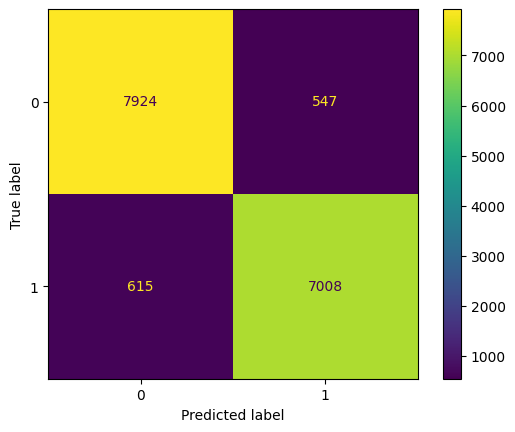

In [18]:
# Generate confusion matrix
conf_matrix_plot(decision_tree, X_test, y_test)

In [ ]:
Notice from this confusion matrix that the model correctly predicts many true negatives and True Positives, this is to be expected, given that the dataset is balanced.



## Plotting the tree
Next, let's examine the splits of the tree. We'll do this by using the plot_tree() function that we imported. We pass to it our fit model as well as some additional parameters. Note that if we did not set max_depth=2, the function would return a plot of the entire tree, all the way down to the leaf nodes. This is intractable and unnecessary. We're most interested in the splits nearest the root, because these tell us the most predictive features.

class_names displays what the majority class of each node is, and filled colors the nodes according to their majority class.

Note that this plot represents how the tree grew from the training data. To make its predictions on the test data, the tree would simply pass each customer in the test data through its splits, from the root node all the way down to a leaf node.

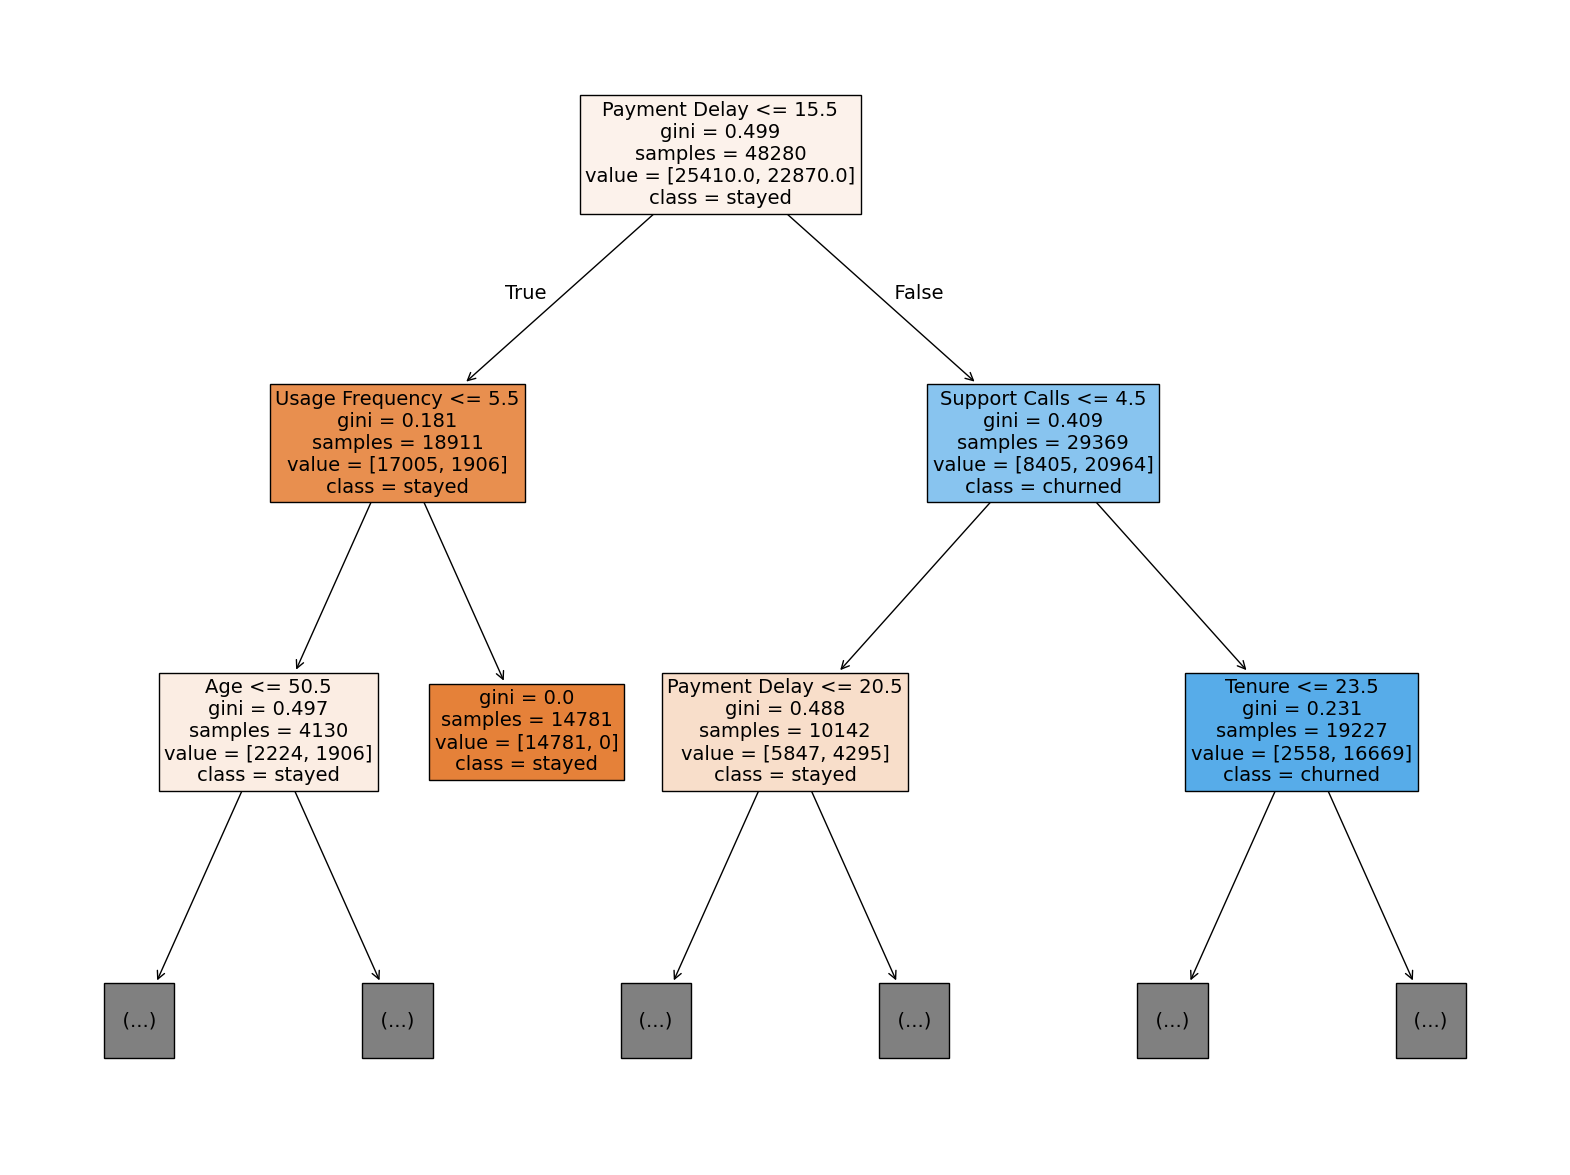

In [19]:
# Plot the tree
plt.figure(figsize=(20,15))
plot_tree(decision_tree, max_depth=2, fontsize=14, feature_names=X.columns, 
          class_names={0:'stayed', 1:'churned'}, filled=True);
plt.show()

This plot tells us that, if we could only do a single split on a single variable, the one that would most help us predict whether a customer will churn is "Payment Delay".

If we look at the nodes at depth one, we notice that the "Usage Frequency" and "Support Calls" are also strong predictors (relative to the features we have) of whether or not they will churn.


## Tune and validate decision trees with Python
Important: 

Throughout the following steps,  will use Python to tune and cross-validate a decision tree model with scikit-learn. 

Using GridSearchCV to tune the following hyperparameters with cross-validation:
max_depth
min_samples_leaf

Cross-validated hyperparameter tuning
Cross-validating a model using GridSearchCV can be done in a number of different ways. If you find notebooks online that other people have written, you'll likely soon discover this for yourself. But all variations must fulfill the same general requirements. (Refer to the GridSearchCV documentation for further reading.)

The format presented below is step-wise, making it easier to follow.

Instantiate the classifier (and set the random_state)

In [20]:
# Instantiate the classifier
tuned_decision_tree = DecisionTreeClassifier(random_state = 42)

In [21]:
# Assign a dictionary of hyperparameters to search over
tree_para = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50],
             'min_samples_leaf': [2, 5, 10, 20, 50]}

In [22]:
# Assign a set of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

Instantiate the GridSearchCV object. Pass as arguments:

The classifier (tuned_decision_tree)
The dictionary of hyperparameters to search over (tree_para)
The set of scoring metrics (scoring)
The number of cross-validation folds you want (cv=5)
The scoring metric that you want GridSearch to use when it selects the "best" model (i.e., the model that performs best on average over all validation folds) (refit='f1'*)


Fit the data (X_train, y_train) to the GridSearchCV object (clf)


In [23]:
%%time
# Ensure that the model and parameters are defined before this code

# Assuming tuned_decision_tree and tree_para are already defined

# Define scoring as a dictionary, if it's not already
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',  # For multiclass problems
    'recall': 'recall_macro',        # For multiclass problems
    'f1': 'f1_macro'                 # For multiclass problems
}

# Instantiate the GridSearch
clf = GridSearchCV(tuned_decision_tree, 
                   tree_para, 
                   scoring=scoring, 
                   cv=5, 
                   refit="f1")  # This will use F1 score for selecting the best model

# Fit the model
clf.fit(X_train, y_train)

CPU times: total: 38.8 s
Wall time: 39.1 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50],
                         'min_samples_leaf': [2, 5, 10, 20, 50]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1_macro',
                      'precision': 'precision_macro',
                      'recall': 'recall_macro'})

In [24]:
print("Best Avg. Validation Score: ", "%.4f" % clf.best_score_)

#Best Avg. Validation Score:  0.9496

Best Avg. Validation Score:  0.9496


In [25]:
def make_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.
  
    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.  
    '''

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                          'F1': [f1],
                          'Recall': [recall],
                          'Precision': [precision],
                          'Accuracy': [accuracy]
                         }
                        )
  
    return table

In [26]:
# Call the function on our model
result_table = make_results("Tuned Decision Tree", clf)

In [27]:
# Save table as csv
result_table.to_csv("Results.csv")

In [28]:
# View the results
result_table 

,Model,F1,Recall,Precision,Accuracy
0,Tuned Decision Tree,0.949559,0.951625,0.950811,0.949565


These results show that our model's performance is really good, we will compare against other models to see which one will do better. 


# Model II

## Cross-validated hyperparameter tuning

1. Instantiate the classifier (and set the random_state).
2. Create a dictionary of hyperparameters to search over.
3. Create a set of scoring metrics to capture.
4. Instantiate the GridSearchCV object. Pass as arguments:
    * The classifier (rf)
    * The dictionary of hyperparameters to search over (cv_params)
    * The set of scoring metrics (scoring)
    * The number of cross-validation folds you want (cv=5)
    * The scoring metric that you want GridSearch to use when it selects the "best" model (i.e., the model that performs best on average over all validation folds) (refit='f1')
5. Fit the data (X_train, y_train) to the GridSearchCV object (rf_cv).

In [29]:
%%time

rf = RandomForestClassifier(random_state=0)

cv_params = {'max_depth': [2,3,4,5, None], 
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4],
             'n_estimators': [75, 100, 125, 150]
             }  

# Define scoring as a dictionary, with each metric mapped to its corresponding string
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',  # Macro average for multiclass
    'recall': 'recall_macro',        # Macro average for multiclass
    'f1': 'f1_macro'                 # Macro average for multiclass
}

rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='f1')

rf_cv.fit(X_train, y_train)  # This will actually fit the model and compute the time

CPU times: total: 1h 54min 48s
Wall time: 1h 56min 53s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [2, 3, 4, 5, None],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [75, 100, 125, 150]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1_macro',
                      'precision': 'precision_macro',
                      'recall': 'recall_macro'})

## Random forest validation

* Using pickle to save a fit model
* Using a separate dataset to tune hyperparameters and validate your model
* Splitting the training data to create a validation dataset
* Creating a list of split indices to use with PredefinedSplit so GridSearchCV performs validation on this defined validation set

In [31]:
# Define the path to the folder where you want to save the model
path = 'C:\\path\\to\\your\\folder\\'

# Check if the directory exists, if not, create it
if not os.path.exists(path):
    os.makedirs(path)

# Assuming 'rf_cv' is your trained model
# Pickle the model
with open(path+'rf_cv_model.pickle', 'wb') as to_write:
    pickle.dump(rf_cv, to_write)

# Read in pickled model
with open(path + 'rf_cv_model.pickle', 'rb') as to_read:
    rf_cv = pickle.load(to_read)

print("Model saved and loaded successfully!")

Model saved and loaded successfully!


Now everything above is ready to run quickly and without refitting. We can continue by using the model's best_params_ attribute to check the hyperparameters that had the best average F1 score across all the cross-validation folds.


In [32]:
print(rf_cv.best_params_)

{'max_depth': None, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 150}


In [33]:
rf_cv.best_score_

np.float64(0.9524821534644564)

Our model had an F1 score of 0.9524821534644564—REALLY GOOD. Recall that when we ran our grid search, we specified that we also wanted to capture precision, recall, and accuracy.



In [57]:
# Make a results table for the rf_cv model using above function
rf_cv_results = make_results('Random Forest CV', rf_cv)
rf_cv_results

,Model,F1,Recall,Precision,Accuracy
0,Random Forest CV,0.952482,0.954694,0.954034,0.952486


In [ ]:
def make_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.
    '''

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                          'F1': [f1],
                          'Recall': [recall],
                          'Precision': [precision],
                          'Accuracy': [accuracy]
                         }
                        )

    return table

We can concatenate these results to our master results table from when we built the single decision tree model.

In [58]:
# Make a results table for the rf_cv model using above function
rf_cv_results = make_results('Random Forest CV', rf_cv)
rf_cv_results
# Read in master results table
result_table = pd.read_csv('Results.csv', index_col=0)
result_table

# Concatenate the random forest results to the master table
result_table = pd.concat([rf_cv_results, result_table])
result_table

,Model,F1,Recall,Precision,Accuracy
0,Random Forest CV,0.952482,0.954694,0.954034,0.952486
0,Tuned Decision Tree,0.949559,0.951625,0.950811,0.949565


# Model III 

## Hyperparameters tuned with separate validation set
Begin by splitting the training data to create a validation dataset. Remember, we won't touch the test data at all.

We'll use train_test_split to divide X_train and y_train into 80% training data (X_tr, y_tr) and 20% validation data (X_val, y_val). Don't forget to stratify it and set the random state.



In [43]:
# Create separate validation data
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, 
                                            stratify=y_train, random_state=10)

When we tune hyperparameters with GridSearchCV using a separate validation dataset, we have to take a few extra steps. GridSearchCV wants to cross-validate the data. In fact, if the cv argument were left blank, it would split the data into five folds for cross-validation by default.

We don't want it to do this. Instead, we're going to tell it exactly which rows of X_train are for training, and which rows are for validation.

To do this, we need to make a list of length len(X_train) where each element is either a 0 or -1. A 0 in index i will indicate to GridSearchCV that index i of X_train is to be held out for validation. A -1 at a given index will indicate that that index of X_train is to be used as training data.

We'll make this list using a list comprehension that looks at the index number of each row in X_train. If that index number is in X_val's list of index numbers, then the list comprehension appends a 0. If it's not, then it appends a -1.

So if our training data is:
[A, B, C, D],
and our list is:
[-1, 0, 0, -1],
then GridSearchCV will use a training set of [A, D] and validation set of [B, C].

In [44]:
# Create list of split indices
split_index = [0 if x in X_val.index else -1 for x in X_train.index]

In [45]:
rf = RandomForestClassifier(random_state=0)

cv_params = {'max_depth': [2,3,4,5, None], 
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4],
             'n_estimators': [75, 100, 125, 150]
             }  

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',  # Macro average for multiclass
    'recall': 'recall_macro',        # Macro average for multiclass
    'f1': 'f1_macro'                 # Macro average for multiclass
}

custom_split = PredefinedSplit(split_index)

rf_val = GridSearchCV(rf, cv_params, scoring=scoring, cv=custom_split, refit='f1')

In [46]:
# Now fit the model.
rf_val.fit(X_train, y_train)


C:\Users\Vanessa\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1,  0, ..., -1, -1])),
             estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [2, 3, 4, 5, None],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [75, 100, 125, 150]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1_macro',
                      'precision': 'precision_macro',
                      'recall': 'recall_macro'})

In [47]:
# Pickle the model
with open(path+'rf_val_model.pickle', 'wb') as to_write:
    pickle.dump(rf_val, to_write)

In [48]:
# Open pickled model
with open(path+'rf_val_model.pickle', 'rb') as to_read:
    rf_val = pickle.load(to_read)

In [49]:
rf_val.best_params_

{'max_depth': None,
 'max_features': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 150}

In [59]:
# Concatentate model results table with master results table
result_table = pd.concat([rf_val_results, result_table])

# Sort master results by F1 score in descending order
result_table.sort_values(by=['F1'], ascending=False)

result_table

,Model,F1,Recall,Precision,Accuracy
0,Random Forest Validated,0.952150,0.954327,0.953619,0.952154
0,Random Forest CV,0.952482,0.954694,0.954034,0.952486
0,Tuned Decision Tree,0.949559,0.951625,0.950811,0.949565


In [60]:
# Save the master results table
result_table.to_csv(path+'results2.csv', index=False);

## Model selection and final results
Now we have three models. If we've decided that we're done trying to optimize them, then we can now use our best model to predict on the test holdout data. We'll be using the cross-validated model without the depth limitation, but if we were instead to use the model that was validated against a separate validation dataset, we'd now go back and retrain the model on the full training set (training + validation sets).


The results in the table above tell us that the cross-validated random forest model performs a little better than the one trained on a separate validation set.

It performs well for precision and accuracy and recall which means that out of all the people in the validation folds who actually left the Company, the model successfully identifies 95% of them.


Insights from the summary:
F1 Score: All models are very close in their F1 scores, with Random Forest CV slightly leading at 0.952.
Recall: The Random Forest CV model has the highest recall (0.955), which means it does the best at identifying positive instances.
Precision: All models have similar precision, with a slight edge for Random Forest CV (0.954).
Accuracy: All models achieve approximately 95% accuracy, with no significant differences between them.
Key takeaways:
Random Forest Validated and Random Forest CV are performing very similarly across all metrics.
Tuned Decision Tree performs slightly worse, with all metrics slightly below those of the Random Forest models.
All models are performing well, and the differences are relatively small.